# MLP

## 例題
MNISTデータセット（手書き数字文字画像）をMLPで分類するプログラムを作成せよ．

### STEP1：インポート
下記ライブラリをインポートする．

- torch
- torch.nn
- torch.nn.functional
- torch.optim
- torchvision
- torchvision.transforms

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

### STEP2：ネットワーク定義
ネットワークを定義するクラスを記述する． 

- クラスはnn.Moduleを継承する
- クラスは```__init__()```と```forward()```というメソッドを定義する
    - ```__init__()```：ネットワークの構造を定義
    - ```forward()```：ネットワークの順伝播を定義
- 全結合層は```nn.Linear```クラスを用いる
- 活性化関数ReLUは```F.relu()```を用いる

In [ ]:
# 任意のクラス名（ここではMLP）をつける
class MLP(nn.Module):

    # ネットワークの構造を定義
    def __init__(self):
        super(MLP, self).__init__()

        # 全結合層1の定義
        # 引数1：入力サイズ = 784（画像のサイズ）
        # 引数2：出力サイズ = 100
        self.fc1 = nn.Linear(784, 100)

        # 全結合層2の定義
        # 引数1：入力サイズ = 100（全結合層1の出力と同じサイズ）
        # 引数2：出力サイズ = 10 （画像のラベル数 0〜9）
        self.fc2 = nn.Linear(100, 10)


    # ネットワークの順伝播を定義
    def forward(self, x):

        # 全結合層1の順伝播＋活性化関数ReLU
        x = self.fc1(x)
        x = F.relu(x)

        # 全結合層2の順伝播
        x = self.fc2(x)

        return x

In [ ]:
# 上記MLPクラスのインスタンスを生成
mlp = MLP()

# 実行するデバイスにインスタンスを移動
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)

### STEP3：誤差関数・最適化器
誤差関数と最適化器を定義する．
- 誤差関数：```nn.MSELoss```と```nn.CrossEntropyLoss```がよく使われる
    - ```nn.MSELoss```：回帰問題でよく使う
    - ```nn.CrossEntropyLoss```：分類問題でよく使う（今回はこちらを使う）
- 最適化器：```optim.SGD```と```optim.Adam```がよく使われる
    - ```optim.SGD```：確率的勾配降下法（今回はこちらを使う）
    - ```optim.Adam```：Adam

In [ ]:
# 誤差関数（クロスエントロピー誤差）の定義
criterion = nn.CrossEntropyLoss()

# 最適化器（確率的勾配降下法）の定義
# 引数1：最適化するネットワークのパラメータ parameters()で取得可能
# 引数2：学習率 = 0.01
optimizer = optim.SGD(mlp.parameters(), lr=0.01)

### STEP4：データセット
データセットを用意する．

- MNISTデータセット（28x28ピクセルの画像）は```torchvision```から読み出す
    - Training用データ（60000枚）
    - Test用データ（10000枚）
- バッチサイズ（一度にネットワークに入力するデータ数）を指定する
    - 大→データセット全てを入力するまでにかかる繰り返し回数が減るため学習時間が短くなるが メモリの消費が大きくなる
    - 小→データセット全てを入力するまでにかかる繰り返し回数が増えるため学習時間が長くなるが メモリの消費が小さくなる

In [ ]:
# ローカル環境で動作させる場合は
#   torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# でデータセットを./dataフォルダにダウンロードできるが，Colabだとダウンロードエラーが生じることがある． 
# 代わりにデータセットを直接ダウンロードし，ダウンロードした場所を指定する対策をとっている．

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [ ]:
# 画像整形の設定
transform_mnist = transforms.Compose([
    # PyTorchではTensor型と呼ばれる配列でデータを取り扱う
    # ここではダウンロードしてきた画像をTensor型に変換する
    transforms.ToTensor(),

    # ダウンロードした画像の値域は[0, 1]だが これを[-1, 1]に整形する
    # 入力画像inputsは下記の式に基づいて変換される
    # inputs[channel] = (inputs[channel] - mean[channel]) / std[channel]
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

# データセットの読み込み
# 引数1：データセットのパス
# 引数2：Training用かTest用か
# 引数3：ダウンロードしてくるか否か
# 引数4：画像整形の設定
trainset_mnist = torchvision.datasets.MNIST(root='./', train=True, download=False, transform=transform_mnist)
testset_mnist = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform_mnist)

# ミニバッチの設定
# 引数1：データセット
# 引数2：バッチサイズ
# 引数3：データをシャッフルするか否か
# Trainingはデータの順番に依存するため 偏りが生じないようにシャッフルすることがある
# Testはデータの順番に依存しないため シャッフルは不要
batchsize = 100
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batchsize, shuffle=True)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=batchsize, shuffle=False)

### STEP5：ネットワーク学習
学習を下記のステップで行う．
- 入力データ・教師データをネットワークに入力
- ネットワークパラメータの微分値をリセット：```optimizer.zero_grad()```
- ネットワークの出力と教師データの誤差を計算
- 誤差逆伝播：```loss.backward()```
- ネットワークパラメータの更新：```optimizer.step()```
- 以上を繰り返す（適宜ネットワークを評価）

In [ ]:
# エポック数：データセットを何周するか
epochs = 2

for epoch in range(epochs):
    running_loss = 0.0

    # for文でTraining用データセットをループする
    for i, data in enumerate(trainloader_mnist, 0):
        # inputs：入力データ
        # labels：教師データ
        inputs, labels = data

        # 入力データが画像なので変形してMLPの入力に合わせる
        inputs = inputs.view(-1, 784)

        # 実行するデバイスにデータを移動
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 入力データを順伝播し出力を確認
        outputs = mlp(inputs)

        # ネットワークパラメータの微分値をリセット
        optimizer.zero_grad()

        # ネットワークの出力と教師データの誤差を計算
        loss = criterion(outputs, labels)

        # 誤差逆伝播
        loss.backward()

        # ネットワークパラメータの更新
        optimizer.step()

        # 誤差のモニタリング
        # 100回に1回
        running_loss += loss.item()
        if i % 100 == 99:
            print("[{}, {}] train loss: {}".format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


    # ネットワークのTest
    test_loss = 0.0
    correct = 0

    # for文でTest用データセットをループする
    for i, data in enumerate(testloader_mnist, 0):
        # 入力データを順伝播しの出力を確認
        inputs, labels = data
        inputs = inputs.view(-1, 784)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mlp(inputs)

        # ネットワークの出力と教師データの誤差を計算
        test_loss += criterion(outputs, labels).item()

        # ネットワークの出力ラベルを確認
        # ネットワークの出力のうちどこが最も大きいかを調べる
        pred = outputs.argmax(dim=1, keepdim=True)

        # ネットワークの出力ラベルと教師データが一致する数を数える
        correct += pred.eq(labels.view_as(pred)).sum().item()

    print("test loss: {}".format(test_loss / len(testloader_mnist)))
    print("test accuracy: {}".format(correct / len(testset_mnist)))

## 演習
FashionMNISTデータセット（衣類画像）をMLPで分類するプログラムを作成せよ．

### STEP1：インポート

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

### STEP2：ネットワーク定義

Note
- 例題とネットワーク構成を変える
- Fashion MNISTの画像サイズは28x28ピクセル
- Fashion MNISTのラベル数は10

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
mlp = MLP()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlp.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

### STEP3：誤差関数・最適化器

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mlp.parameters(), lr=0.01)

### STEP4：データセット


In [ ]:
transform_fashion = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

trainset_fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion)
testset_fashion = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion)

batchsize = 100
trainloader_fashion = torch.utils.data.DataLoader(trainset_fashion, batch_size=batchsize, shuffle=True)
testloader_fashion = torch.utils.data.DataLoader(testset_fashion, batch_size=batchsize, shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


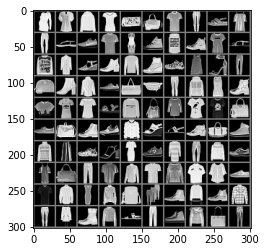

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dataiter = iter(trainloader_fashion)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images, nrow=10)
img = img / 2 + 0.5

npimg = img.numpy()
npimg = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg)
plt.show()

### STEP5：ネットワーク学習

In [ ]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader_fashion, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 784)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mlp(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print("[{}, {}] train loss: {}".format(epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    test_loss = 0.0
    correct = 0

    for i, data in enumerate(testloader_fashion, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 784)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = mlp(inputs)

        test_loss += criterion(outputs, labels).item()

        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

    print("test loss: {}".format(test_loss / len(testloader_fashion)))
    print("test accuracy: {}".format(correct / len(testset_fashion)))

[1, 100] train loss: 1.5737137174606324
[1, 200] train loss: 0.9464787793159485
[1, 300] train loss: 0.7643005084991455
[1, 400] train loss: 0.7105289733409882
[1, 500] train loss: 0.650871214568615
[1, 600] train loss: 0.6275904268026352
test loss: 1
test accuracy: 0.7766
[2, 100] train loss: 0.6007549694180488
[2, 200] train loss: 0.5663689026236534
[2, 300] train loss: 0.5565962487459183
[2, 400] train loss: 0.5578021785616875
[2, 500] train loss: 0.53576664686203
[2, 600] train loss: 0.5332491871714592
test loss: 2
test accuracy: 0.8064
[3, 100] train loss: 0.5219547712802887
[3, 200] train loss: 0.5146856150031089
[3, 300] train loss: 0.49951363265514376
[3, 400] train loss: 0.4987144793570042
[3, 500] train loss: 0.48296478182077407
[3, 600] train loss: 0.4877037566900253
test loss: 3
test accuracy: 0.819
[4, 100] train loss: 0.4834045451879501
[4, 200] train loss: 0.4714825648069382
[4, 300] train loss: 0.46793735831975936
[4, 400] train loss: 0.47360270500183105
[4, 500] train 